In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import GRU, LSTM, InputLayer, Dense, Dropout
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf

In [2]:
#pip install yfinance


In [2]:
# Set the seed to generate the same sequence of randomness during multiple executions of the notebook.
seed = 35
tf.random.set_seed(seed)

# Load Amazon stock data from Yahoo Finance from 2001-01-02 to 2024-07-08
ticker = "AMZN"
df = yf.download(ticker, start="2001-01-02", end="2024-07-08")

# Drop any rows with NaN values
df.dropna(inplace=True)

# Preprocess the data by min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

# Create the time series data structure
look_back = 30  # Look back period is one month.

# Use 80% of data for training and 20% for testing
train_size = int(len(scaled_data) * 0.80)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - look_back:]

# Generate training and testing sequences of data
train_generator = TimeseriesGenerator(train_data, train_data,
                                     length=look_back, batch_size=32)
test_generator = TimeseriesGenerator(test_data, test_data,
                                     length=look_back, batch_size=1)

[*********************100%%**********************]  1 of 1 completed


In [3]:
print(train_generator)

print(len(test_generator))

1183


In [3]:
df.reset_index(inplace=True)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,0.790625,0.800000,0.681250,0.693750,0.693750,184070000
1,2001-01-03,0.681250,0.893750,0.678125,0.878125,0.878125,293608000
2,2001-01-04,0.850000,0.878125,0.771875,0.775000,0.775000,212410000
3,2001-01-05,0.775000,0.793750,0.678125,0.728125,0.728125,175976000
4,2001-01-08,0.721875,0.778125,0.687500,0.746875,0.746875,208894000
...,...,...,...,...,...,...,...
5908,2024-06-28,197.729996,198.850006,192.500000,193.250000,193.250000,76930200
5909,2024-07-01,193.490005,198.300003,192.820007,197.199997,197.199997,41192000
5910,2024-07-02,197.279999,200.429993,195.929993,200.000000,200.000000,45600000
5911,2024-07-03,199.940002,200.029999,196.759995,197.589996,197.589996,31597900


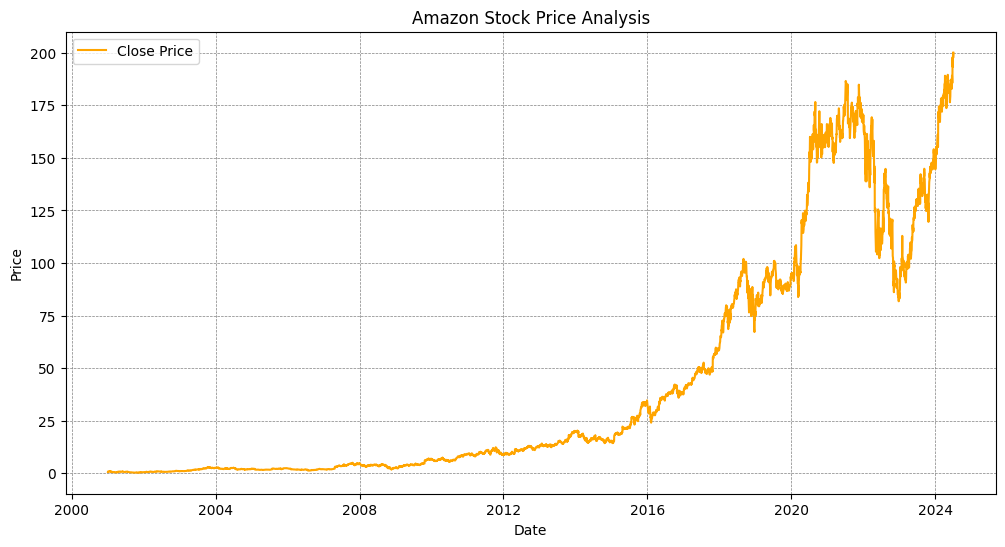

In [6]:
# Plotting the closing price
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(df["Date"], df["Close"], label='Close Price', color='orange')
plt.title("Amazon Stock Price Analysis")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.gca().set_facecolor('white')  # Plot background
plt.gcf().set_facecolor('white')  # Figure background
plt.legend()
plt.show()

200 and 300 as it is for long term and very long term use

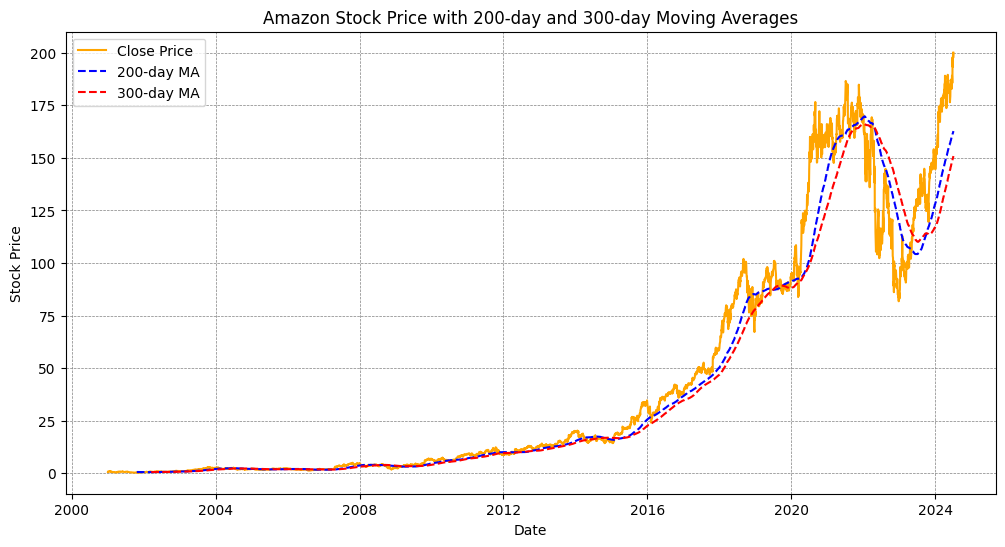

In [7]:
# Calculate the 200-day and 300-day moving averages
df['MA_200'] = df['Close'].rolling(window=200).mean()  # 200-day Moving Average
df['MA_300'] = df['Close'].rolling(window=300).mean()  # 300-day Moving Average

# Plotting the closing price and moving averages
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["Close"], label='Close Price', color='orange')
plt.plot(df["Date"], df['MA_200'], label='200-day MA', linestyle='--', color='b')
plt.plot(df["Date"], df['MA_300'], label='300-day MA', linestyle='--', color='r')
plt.title("Amazon Stock Price with 200-day and 300-day Moving Averages")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')
plt.legend()
plt.show()

In [4]:
# Building the LSTM model

lstm_model = Sequential()

lstm_model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(look_back, 1)))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=60, activation='relu', return_sequences=True))
lstm_model.add(Dropout(0.3))

lstm_model.add(LSTM(units=80, activation='relu', return_sequences=True))
lstm_model.add(Dropout(0.4))

lstm_model.add(LSTM(units=120, activation='relu', return_sequences=False))
lstm_model.add(Dropout(0.5))

lstm_model.add(Dense(units=1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
import tensorflow.keras.backend as K

# Define the custom RMSE metric
def root_mean_squared_error(y_true, y_pred):
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [5]:
# Adding early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fitting the model
history = lstm_model.fit(train_generator, epochs=100, validation_data=test_generator, callbacks=[early_stopping])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


147/147 ━━━━━━━━━━━━━━━━━━━━ 67s 390ms/step - loss: 0.0131 - mean_absolute_error: 0.0779 - val_loss: 0.3316 - val_mean_absolute_error: 0.5614
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 34s 232ms/step - loss: 0.0073 - mean_absolute_error: 0.0596 - val_loss: 0.0055 - val_mean_absolute_error: 0.0593
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 40s 222ms/step - loss: 0.0013 - mean_absolute_error: 0.0213 - val_loss: 0.0166 - val_mean_absolute_error: 0.1184
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 40s 212ms/step - loss: 0.0011 - mean_absolute_error: 0.0203 - val_loss: 0.0077 - val_mean_absolute_error: 0.0763
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 34s 229ms/step - loss: 7.5872e-04 - mean_absolute_error: 0.0174 - val_loss: 0.0031 - val_mean_absolute_error: 0.0415
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 40s 226ms/step - loss: 0.0010 - mean_absolute_error: 0.0200 - val_loss: 0.0027 - val_mean_absolute_error: 0.0416
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 231ms/step - loss: 0.0011 - mean_absolu

In [20]:
lstm_model.save("lstm.keras")

#file path:  /content/lstm.keras

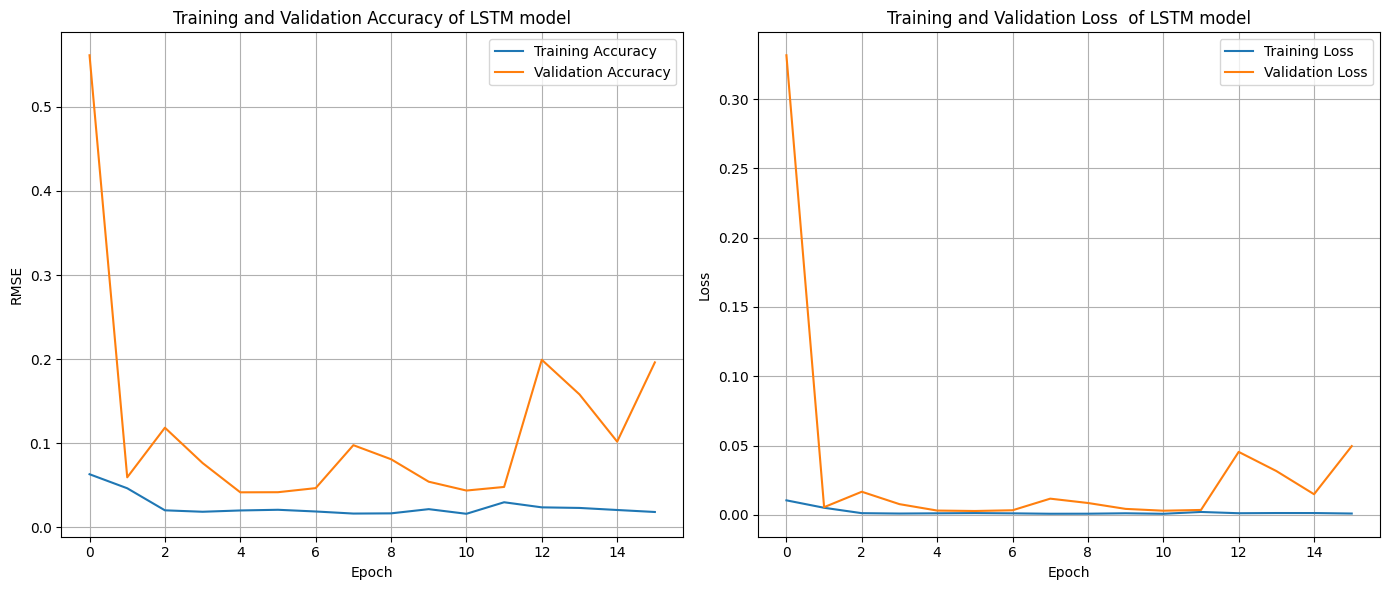

In [9]:
# Create a 1x2 subplot layout
plt.figure(figsize=(14, 6))

# First subplot: RMSE
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history.history['mean_absolute_error'], label='Training Accuracy')
plt.plot(history.history['val_mean_absolute_error'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy of LSTM model')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

# Second subplot: Loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss  of LSTM model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

In [12]:
# Evaluate the model on the test data
loss, accuracy = lstm_model.evaluate(test_generator)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


1183/1183 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - loss: 0.0024 - mean_absolute_error: 0.0363
Test Loss: 0.0027407880406826735, Test Accuacy: 0.041637443006038666


In [13]:
# Make predictions
predictions = lstm_model.predict(test_generator)
predictions = scaler.inverse_transform(predictions)

predictions = predictions[look_back:]   # Shifting by a look_back number of days

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step


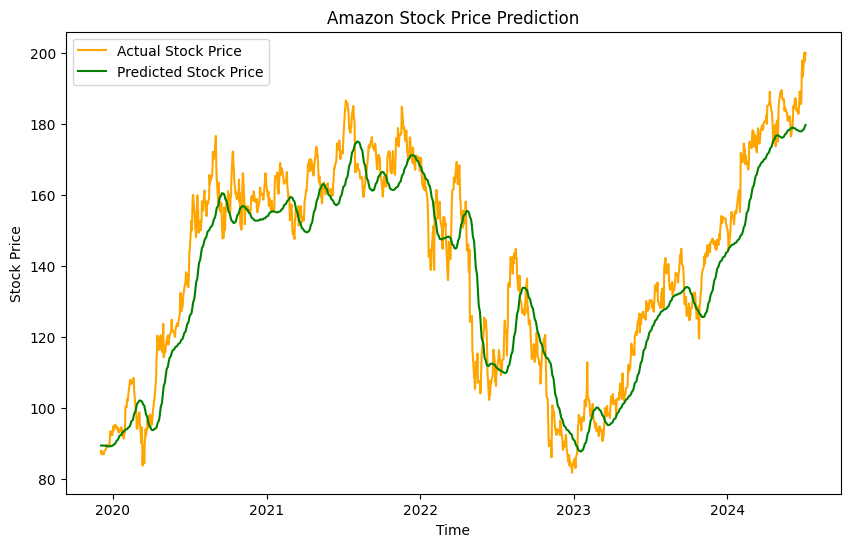

In [36]:
# Plot the predictions
test_data = df['Close'][train_size:].values[look_back:]
plt.figure(figsize=(10, 6))

# Extract the dates corresponding to the test period
test_dates = df['Date'][train_size + look_back:].values
predictions = predictions[:len(test_dates)]

plt.plot(test_dates, test_data, color='orange', label='Actual Stock Price')
plt.plot(test_dates, predictions, color='green', label='Predicted Stock Price')
plt.title('Amazon Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()